<center>
    
#  IO Problem Set 3: DDC 

## December 2, 2019
## Rachel Anderson 

</center>

### 0.  Load packages, set up state space and parameters

In [256]:
using Optim, Statistics, LinearAlgebra, Distributions
using Plots, Random, DataFrames, StatsBase

In [257]:
X = collect(0:0.01:49.99);
β = 0.5;
θ = [0.5 3];

# Construct transition matrix using log normal
F = LogNormal();
P = [ cdf(F, k+0.01) - cdf(F, k) for k=collect(0.01:0.01:50)];
Γ = [ (j <= i) ? 0 : P[j-i] for i=1:length(X), j=1:length(X)];
Γ = Γ./sum(Γ,dims=2);
# Fix last row so that prob's sum to one
Γ[length(X),:] = hcat(zeros(4999)', 1);

### 1. Compute choice-specific value functions

In [258]:
function cvf(X,V,θ)
    v=zeros(2,length(X))
    EV = getEV(X,V)
    v[1,:] = -θ[1] * X + β*EV[1,:]
    v[2,:] = -θ[2] * ones(length(X)) + β*EV[2,:]
    return v
end

cvf (generic function with 2 methods)

In [259]:
function getEV(X,V)
    EV = zeros(2,length(X))
    EV[1,:] = Γ*V  # expected value calculated according to P(x' | x)
    EV[2,:] = V[1]*ones(length(X)) # continuation value after replace is constant
    return EV
end

getEV (generic function with 1 method)

In [260]:
function emax(v)
    return(log.(exp.(v[1,:]) + exp.(v[2,:])))
end


emax (generic function with 1 method)

In [261]:
function iterateValues(X,V,θ)
    return emax(cvf(X,V,θ)) 
end

iterateValues (generic function with 2 methods)

In [262]:
function solveBellmanEquation(X,θ)
    Vold = zeros(length(X))
    Vnew = ones(length(X)) 
    tol = 1e-3
    while (norm(Vnew - Vold) >= tol)
        Vold = Vnew
        Vnew = iterateValues(X,Vold,θ)
    end
    return Vnew
end

solveBellmanEquation (generic function with 2 methods)

In [263]:
@time begin
V = solveBellmanEquation(X,θ);
end

  0.193988 seconds (70.60 k allocations: 19.088 MiB)


5000-element Array{Float64,1}:
 -0.7171374056436556
 -0.7243916028531326
 -0.731636871532941 
 -0.7388731871702726
 -0.7461005252615298
 -0.7533188613131864
 -0.7605281708426044
 -0.7677284293788934
 -0.7749196124637591
 -0.7821016956523562
 -0.7892746545141568
 -0.7964384646338063
 -0.803593101611995 
  ⋮                 
 -3.3585633125682577
 -3.358563312568652 
 -3.358563312569044 
 -3.3585633125694345
 -3.358563312569823 
 -3.35856331257021  
 -3.3585633125705945
 -3.3585633125709773
 -3.358563312571358 
 -3.3585633125717367
 -3.3585633125721137
 -3.358563312572489 

In [264]:
v = cvf(X,V,θ);

### 3. Plot $v(a,x)$ and $V(x)$

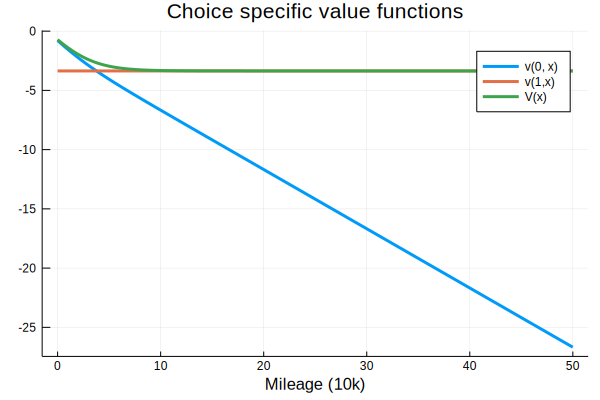

In [265]:
plot(X, [transpose(v) V], 
    title="Choice specific value functions",
    label=["v(0, x)" "v(1,x)" "V(x)"],
    lw=3, 
    xlabel="Mileage (10k)")

As expected, the value of not replacing the engine exceeds the value of replacing the engine for small values of $x$.  However, there exists a cutoff value $x^*$ such that $v(0, x^*) = v(1, x^*)$.  The value function $V(x)$ approximately traces $\max \{v(0,x), v(1,x)\}$, where the curvature comes from the discount factor $\beta$.

### 3.  Find expected replacement mileage $x^*$

The solution involves a complicated integral so I solve by simulation together with part 4.

In [266]:
function pchoose(v)
    p = zeros(2,size(v,2))
    num = exp.(v[2,:])
    denom = num + exp.(v[1,:])
    p[2,:] = num./denom
    p[1,:] = ones(size(v,2)) - p[2,:]
    return p
end

pchoose (generic function with 1 method)

### 4. Generate T=20,000 observable states and choices

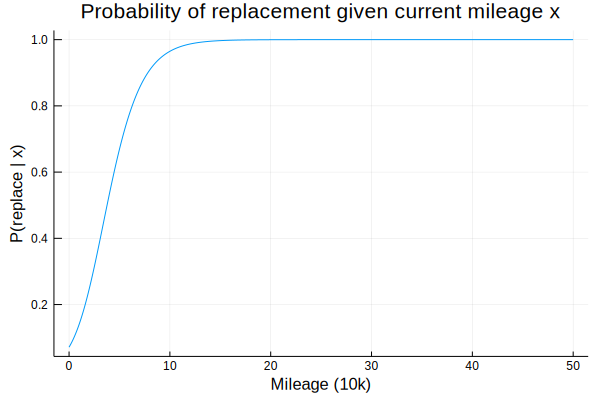

In [267]:
p = pchoose(v)
plot(X,p[2,:],title="Probability of replacement given current mileage x", label = "", xlabel="Mileage (10k)", ylabel="P(replace | x)")

In [268]:
T = 20000;
state = repeat(Int16[1],T)
action = repeat(Int16[1],T)
replacement_states = []
for t in 1:(T-1)
    if rand() > p[1,state[t]]
        # more valuable to replace
        push!(replacement_states,state[t])
        action[t] = 2
        state[t+1] = 1  
    else 
        state[t+1] = findall(rand() .< cumsum(Γ[state[t],:]))[1]
    end
end

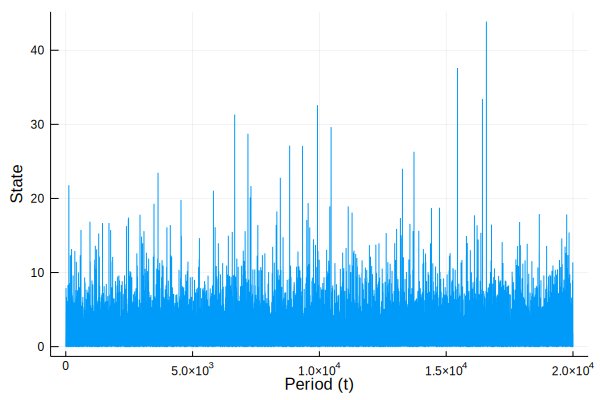

In [269]:
plot(1:T, X[state],xlabel="Period (t)",ylabel="State", label="")

### Mean replacement mileage $x^*$

In [270]:
mean(X[replacement_states]*10000)

41580.24494142705

### 5. Estimate $\theta$ via MLE

I begin by discretizing $\Delta x$ into bins, as in Rust (1987).  Observe first the non-discretized states:

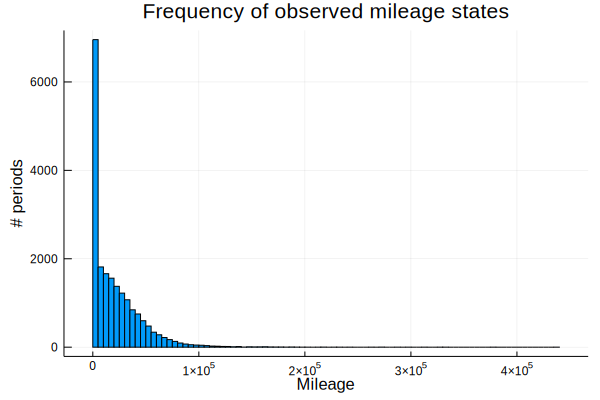

In [271]:
histogram(X[state]*10000, label="", title="Frequency of observed mileage states", xlabel="Mileage", ylabel="# periods")

We will use the $5 \times 5$ state space implied by the quartiles to create to estimate $F_0$ and $F_1$, the transition probabilities conditional on $a_t = 0$ and $a_t = 1$ respectively. 

In [272]:
function reduce_states(state, stateBins)
    smallStates = ones(T)
    for t in 1:T
        if state[t] > stateBins[1] && state[t] <= stateBins[2]
            smallStates[t] = 2
        elseif state[t] > stateBins[2] && state[t] < stateBins[3]
            smallStates[t] = 3
        elseif state[t] >= stateBins[3] && state[t] < stateBins[4]
            smallStates[t] = 4
        elseif state[t] >= stateBins[4]
            smallStates[t] =5
        end
    end
    return smallStates         
end

reduce_states (generic function with 1 method)

In [273]:
stateBins = percentile(state, collect(20:20:100));
newStates = reduce_states(state, stateBins);
newX = [newStates[t] for t in 1:length(newStates)];

The function below calculates $F_0$ and $F_1$ for the reduced state space.

In [274]:
function calculate_F(newStates, action)
    F = zeros(5,5,2)
    for t in 1:(T-1)
        F[Int(newStates[t]), Int(newStates[t+1]),action[t]] += 1
    end
    for i in 1:2  
        F[:,:,i] = F[:,:,i]./sum(F[:,:,i], dims=2)
    end
    return F
end


calculate_F (generic function with 1 method)

The resulting transition matrices are:

In [275]:
F = calculate_F(newStates, action)

5×5×2 Array{Float64,3}:
[:, :, 1] =
 0.0  0.396898  0.353437  0.149722  0.0999426
 0.0  0.137705  0.525995  0.217799  0.118501 
 0.0  0.0       0.310303  0.479091  0.210606 
 0.0  0.0       0.0       0.454084  0.545916 
 0.0  0.0       0.0       0.0       1.0      

[:, :, 2] =
 1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0

Below I introduce the same functions as before, but allow the user to supply the reduced state space $X$ and estimated transition matrix $F$. 

In [278]:
function cvf(F,X,V,θ)
    v=zeros(2,length(X))
    EV = getEV(X,V)
    v[1,:] = -θ[1] * X + β*EV[1,:]
    v[2,:] = -θ[2] * ones(length(X)) + β*EV[2,:]
    return v
end

function getEV(X,V)
    EV = zeros(2,length(X))
    EV[1,:] = F[:,:,1]*V  # expected value calculated according to P(x' | x)
    EV[2,:] = V[1]*ones(length(X)) # continuation value after replace is constant
    return EV
end

function emax(v)
    return(log.(exp.(v[1,:]) + exp.(v[2,:])))
end


function iterateValues(F,X,V,θ)
    return emax(cvf(F,X,V,θ)) 
end

function solveBellmanEquation(F,X,θ)
    Vold = zeros(length(X))
    Vnew = ones(length(X)) 
    tol = 1e-3
    while (norm(Vnew - Vold) >= tol)
        Vold = Vnew
        Vnew = iterateValues(F,X,Vold,θ)
    end
    return Vnew
end

solveBellmanEquation (generic function with 2 methods)

We can see that the value functions using the true parameters $\theta$ are reasonable. 

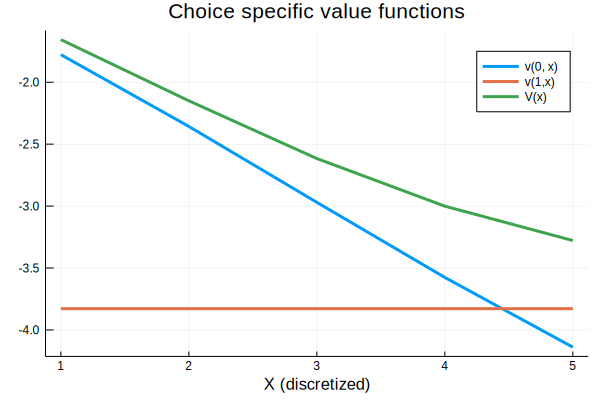

In [283]:
V = solveBellmanEquation(F,1:5, θ)
v = cvf(F,1:5,V,θ)
plot(1:5, [transpose(v) V], 
    title="Choice specific value functions",
    label=["v(0, x)" "v(1,x)" "V(x)"],
    lw=3, 
    xlabel="X (discretized)")

#### Now we find the MLE using the NFXP algorithm for the simulated and discretized data.

In [284]:
function llh(state, action, v)
    llh = 0
    p = pchoose(v)
    for t in 1:length(action)
        llh += log(p[Int(action[t]), Int(state[t])])
    end
    return llh
end

llh (generic function with 1 method)

In [285]:
llh(newStates,action,v)

-9580.591517651304

In [286]:
function outerLoop(F,X,θ)
    
    # inner loop
    V = solveBellmanEquation(F,X, θ)
    v = cvf(F,X,V,θ)
    
    #outer loop = evaluate likelihood given params
    return llh(newStates,action,v)
end

outerLoop (generic function with 1 method)

In [287]:
outerLoop(F,1:5,θ)

-9580.591517651304

In [288]:
θ_0 = [0.3 2.5]
@time res = optimize(z -> -outerLoop(F,1:5,z),θ_0)
θ_mle = res.minimizer
@show θ_mle

  0.037858 seconds (82.58 k allocations: 6.426 MiB)
θ_mle = [0.7665432425434002 4.617135888148053]


1×2 Array{Float64,2}:
 0.766543  4.61714

The estimated ($\theta, RC$) = $(0.7665, 4.617)$ which is reasonable considering the cost of maintenace should no longer be linear in the state space because of how we aggregated the data into discrete states. 

### 6. Hotz and Miller CCP approach

The function below non-parametrically estimates $P(a | x)$ for the discretized state $X$. 

In [290]:
function est_p_replace(newStates, action)
    N = Int(maximum(newStates))
    P = zeros(N)
    denom = zeros(N)
    for t in 1:T
        denom[Int(newStates[t])] +=1 
        if action[t] == 2
            P[Int(newStates[t])] += 1
        end
      
    end
    return P./denom
end

est_p_replace (generic function with 1 method)

The probabilities are as follows, where the first row is the condtiional probability of choosing $a=0$, and the second row is $P(a = 1 |x)$.

In [304]:
pArray = est_p_replace(newStates,action);
pArray = hcat(ones(length(pArray)).-pArray, pArray)'

2×5 Adjoint{Float64,Array{Float64,2}}:
 0.927063  0.901986   0.826446  0.641353  0.285928
 0.072937  0.0980144  0.173554  0.358647  0.714072

In [305]:
function calc_u(x,θ)
    u = zeros(2)
    u[1] = -θ[1]*x
    u[2] = -θ[2]
    return u
end
    
function unconditional_trans(P, F)
    #P = P(a =  1 | x)
    #F = P(x' | x, a = 1)
    #P(x' | x) = P(x'|x a =1)P(a=1 |x ) + P(x'|x a=0)P(a=0 | x) 
    return pArray[1,:]' .* F[:,:,1] + pArray[2,:]' .* F[:,:,2]
end

unconditional_trans (generic function with 1 method)

The unconditional transition probabilities are:

In [310]:
uncond_trans = unconditional_trans(pArray,F)

5×5 Array{Float64,2}:
 0.072937  0.357997  0.292096  0.096025  0.0285764
 0.072937  0.124208  0.434707  0.139686  0.0338828
 0.072937  0.0       0.256449  0.307267  0.0602181
 0.072937  0.0       0.0       0.291228  0.156093 
 0.072937  0.0       0.0       0.0       0.285928 

The function below takes as inputs an initial action and state $(a,x)$ and simulates *nSim* paths of length *capT*.  It is important to keep the paths constant as I search for $\theta$ that minimizes the distance between the simulated probabilities and the probabilities estimated nonparametrically from the data. 

In [311]:
function forward_sim(a,x,numSim,capT)
    xPaths = zeros(numSim, capT)
    aPaths = zeros(numSim, capT)
    xPaths[:,1] = fill(x, numSim)
    aPaths[:,1] = fill(a, numSim)
    for s in 1:numSim
        for t in 2:capT
            xPaths[s,t] = findall(rand().<cumsum(F[Int(xPaths[s,t-1]),:,Int(aPaths[s,t-1])]))[1]
            aPaths[s,t] = (rand() > pArray[1,Int(aPaths[s,t-1])]) + 1
        end
    end
    return [xPaths, aPaths] 
end


forward_sim (generic function with 2 methods)

In [312]:
function eval_sim(θ, sims)
    tSum = 0 
    xPath = sims[1]
    aPath =sims[2]
    nSim = size(xPath,1)
    for s in 1:nSim
       for t in 1:size(xPath,2)
            tSum += β^(t-1)*calc_u(xPath[s,t], θ)[Int(aPath[s,t])]
        end
    end
    return(tSum/nSim)
end

eval_sim (generic function with 2 methods)

In [313]:
function calc_pSim(vSim)
    pSim = zeros(size(vSim,2))
    num = exp.(vSim[2,:])
    denom = num + exp.(vSim[1,:])
    return num./denom
end

calc_pSim (generic function with 1 method)

In [314]:
collectSims = [forward_sim(a,x, 100, 1000) for a=1:2, x=1:5];

In [315]:
function p_obj(θ) 
    vSim = [eval_sim(θ, collectSims[a,x]) for a=1:2, x=1:5]
    pSim = calc_pSim(vSim)
    return norm(log.(pArray[2,:])- log.(pSim))
end


p_obj (generic function with 1 method)

In [316]:
@time res = optimize(z -> p_obj(z),θ_mle)
θ_ccp = res.minimizer
@show θ_ccp

  9.789885 seconds (389.95 M allocations: 11.111 GiB, 18.03% gc time)
θ_ccp = [0.5336433516864435 3.822770719102786]


1×2 Array{Float64,2}:
 0.533643  3.82277

The estimates from the Hotz-Miller approach are $(\theta, RC) = (0.533, 3.8277)$, which is closer to the truth than the NFXP approach. 

### 7.  Studying for generals

Rachel is studying for her IO general exam, which she will take at time $T$.  If she passes the exam, she receives utility $U > 0$; and she receives utility $-K$ if she fails (where $K$ is a large constant).  

Rachel increases her probability of passing by accumulating knowledge in each period, denoted $x_t \in X = [0,1]$.  At time $T$, the probability that she passes the exam is distributed as a Bernoulli random variable with parameter $X_T$, so her expected payoff from entering the exam with knowledge $X_T$ is 

$$ \text{Expected utility} | X_T =  X_T \cdot U - (1-X_T) \cdot K $$

Rachel begins studying with initial knowledge $x_0 = \varepsilon > 0$.  Each period she chooses an effort level $e_t \in \{e_L,e_H\}$, which impacts her knowledge accummulation process $P(x_{t+1} | x_t, e)$ and flow utility.  The transition process satisfies the process that if $e = e_H$, then $x_{t+1} > x_t$ with probability 1, and $P(x_{t+1} | x_t, e_H) > P(x_{t+1} | x_t, e_L)$ for all values $x_{t+1} > x_t$.   If $e = e_L$, there is positive probability that $x_{t+1} < x_t$, so that Rachel's cumulative knowledge decreases in the next period. 

The flow utilities from each effort level are:
$$ u_t(e_t, x_t; \theta)= \begin{cases} -c_H & \text{if $e_t = e_H$}\\ 
                                  \alpha_t(x_t) & \text{if $e_t = e_L$} \end{cases}$$
    
so that the cost of studying hard $(c_H)$ is constant for all $t$, and the utility from exerting low effort is parameterized as,

$$\alpha_t(x_t) = -\beta_1 t + \beta_2 x_t - \beta_3 x_t^2 $$

so that the return to procrastinating increases with $x_t$, but at a diminishing rate; and the overall return to procrastinating is increasing in $t$ (i.e. as the exam date $T$ approaches).   Additionally, Rachel observes shocks $\varepsilon_{H,t}$ and $\varepsilon_{L,t}$ that impact the returns to her effort every period, so that her value from each action can be written as,

$$ v_t(e_t, x_t, \epsilon_t; \theta)= \begin{cases} -c_H + \varepsilon_{H,t} + \sum_{j=t+1}^T \beta^{j-t} E[V_{j}(x_{t+1}, \epsilon_{t+1}) | e_H, x_t, \epsilon_t] & \text{if } e_t = e_H \\
\alpha_t(x_t) + \varepsilon_{L,t} + \sum_{j=t+1}^T \beta^{j-t} E[V_{j}(x_{t+1}, \epsilon_{t+1}) | e_L, x_t, \epsilon_t] & \text{if } e_t = e_L 
\end{cases} $$

where the structural erros $\varepsilon_{\cdot, t}$ are mutually independent and identically distributed errors from a Type I Extreme Value distribution. 



Like the "Patent as Options" paper, we solve the problem via backward induction to obtain the optimal study strategy $\{e_t(x)\}$ for $t=1,\dots T$.  

\begin{align*}
V_T (x) &= x \cdot (U+K) - K \\ 
V_{T-1}(x,\varepsilon) &= \max_{e\in{\{e_L,e_H\}}} \{ v(e,x. \varepsilon) + \beta(U+K) E[X_T | X_{T-1}, e] - K\} \\
V_{T-2}(x,\varepsilon) &= \max_{e\in{\{e_L,e_H\}}} \{ v(e,x, \varepsilon) + \beta EV_{T-1}(x',\varepsilon')| x, \varepsilon] \} 
\end{align*} 

$$\vdots $$
$$V_1(x_0, \varepsilon_0) = \max_{e \in \{e_L,e_H\} } \{ v(e,x_0, \varepsilon_0 + \beta E[V_2(x',\varepsilon')| x_0, \varepsilon_0] \}  $$